In [1]:
import matplotlib.pyplot as plt 
import pickle
from tensorflow.python.keras.models import load_model
import numpy as np
import seaborn as sns
import random
from PIL import Image
import cv2
import os



In [2]:
print(os.listdir('.'))
model_path = './models/Unet-best_weights.hdf5'
history_path = './data/Unet-dataset1.pickle'
X_test_dir = 'data/dataset1-X_test.pickle'
y_test_dir = 'data/dataset1-y_test.pickle'

nClasses=12
crop_width = 224
crop_height = 224
input_channel = 3

# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

['FCN-VOC21012-keras.py', 'README.md', 'models', 'data', '.vscode', 'test', 'FCN-dataset1-generator.py', 'FCN-dataset1-keras.py', 'logs', '.git', 'Unet-dataset1.py', '.gitignore', 'experiments', 'utils', 'models.py', 'notes', '__pycache__', 'Unet_ResNet-dataset1.py']


In [3]:
def pair_random_crop(x, y, random_crop_size, data_format, sync_seed=None, **kwargs):
        np.random.seed(sync_seed)
        if data_format == 'channels_first':
            h, w = x.shape[1], x.shape[2]
        elif data_format == 'channels_last':
            h, w = x.shape[0], x.shape[1]           # get height and width
        # get difference from origin height and croped image height
        rangeh = (h - random_crop_size[0]) // 2
        rangew = (w - random_crop_size[1]) // 2
        offseth = 0 if rangeh == 0 else np.random.randint(
            rangeh)  # get random offset height and width
        offsetw = 0 if rangew == 0 else np.random.randint(rangew)

        h_start, h_end = offseth, offseth + \
            random_crop_size[0]     # height + random crop size
        w_start, w_end = offsetw, offsetw + \
            random_crop_size[1]  # width + random crop size

        if data_format == 'channels_first':
            return x[:, h_start:h_end, w_start:w_end], y[:, h_start:h_end, h_start:h_end]
        elif data_format == 'channels_last':
            return x[h_start:h_end, w_start:w_end, :], y[h_start:h_end, w_start:w_end, :]

def getSegmentationArr(path, nClasses,  width, height):
        
        img = cv2.imread(path, 1)
        seg_labels = np.zeros((img.shape[0], img.shape[1], nClasses))
        #img = cv2.resize(img, (width, height))
        img = img[:, :, 0]

        for c in range(nClasses):
            seg_labels[:, :, c] = (img == c).astype(int)
        return seg_labels

def getTestData(test_dir_img, test_dir_seg):
    images = os.listdir(test_dir_img)
    images.sort()
    segmentations  = os.listdir(test_dir_seg)
    segmentations.sort()
    X = []
    Y = []
    for im , seg in zip(images,segmentations) :
        img = cv2.imread(test_dir_img+im)  # 读取训练数据   
        img = np.array(img)
        # print(img.shape)
        label = getSegmentationArr(test_dir_seg+seg, nClasses,crop_width, crop_height)
        img, label = pair_random_crop(img, label, (crop_height, crop_width), 'channels_last')

        img = np.float32(img) / 127.5 - 1  # 归一化
        X.append(img)
        Y.append(label)

    X, Y = np.array(X) , np.array(Y)
    print(X.shape,Y.shape)
    return X, Y

In [4]:
model = load_model(model_path)
pickle_in = open(history_path,"rb")
history = pickle.load(pickle_in)
# X_test, y_test = getTestData(test_dir_img, test_dir_seg)

pickle_in = open(X_test_dir,"rb")
X_test = pickle.load(pickle_in)

pickle_in = open(y_test_dir, "rb")
y_test = pickle.load(pickle_in)


(56, 224, 224, 3) (56, 224, 224, 12)


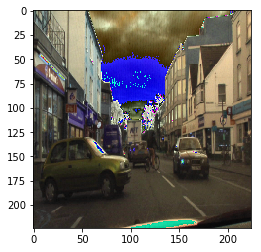

In [5]:
print(X_test.shape, y_test.shape)

fnm = X_test[0]
plt.imshow(fnm)
plt.show()

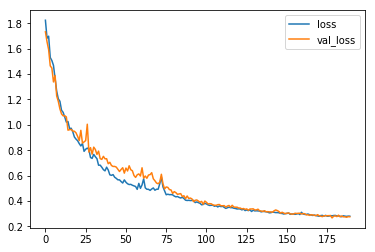

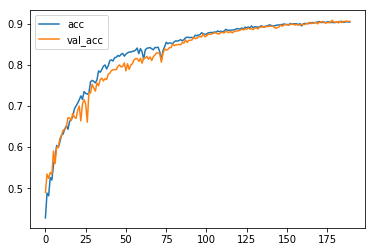

In [6]:
for key in ['loss', 'val_loss']:
    plt.plot(history[key],label=key)
plt.legend()
plt.savefig('./notes/image/Unet-dataset1-loss_val_loss.png',bbox_inches = 'tight', dpi=300)
plt.show()
for key in ['acc', 'val_acc']:
    plt.plot(history[key],label=key)
plt.legend()
plt.savefig('./notes/image/Unet-dataset1-acc_val_acc.png',bbox_inches = 'tight', dpi=300)
plt.show()

In [7]:

y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_predi.shape, y_testi.shape)





(56, 224, 224) (56, 224, 224)


In [8]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP=246734, #FP= 38910, #FN=173106, IoU=0.538
class 01: #TP=566080, #FP=561078, #FN=160236, IoU=0.440
class 02: #TP=  2296, #FP= 15739, #FN=27665, IoU=0.050
class 03: #TP=267033, #FP=  8703, #FN=600431, IoU=0.305
class 04: #TP= 32572, #FP=144479, #FN=110899, IoU=0.113
class 05: #TP=189094, #FP=214809, #FN=67965, IoU=0.401
class 06: #TP=  6107, #FP= 28735, #FN=23836, IoU=0.104
class 07: #TP=  8894, #FP=  9831, #FN=23309, IoU=0.212
class 08: #TP= 49335, #FP= 26853, #FN=126864, IoU=0.243
class 09: #TP=  1323, #FP=  5656, #FN=18705, IoU=0.052
class 10: #TP=     9, #FP=  2790, #FN=11597, IoU=0.001
class 11: #TP= 33984, #FP=348812, #FN=61782, IoU=0.076
_________________
Mean IoU: 0.211


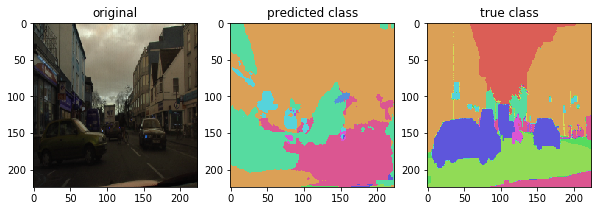

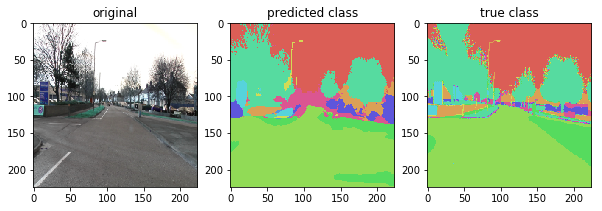

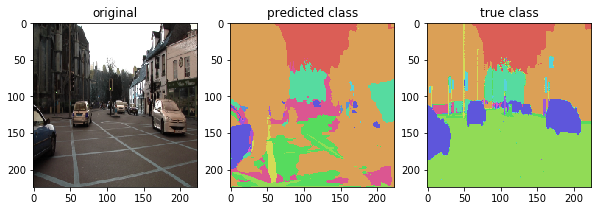

In [9]:

def give_color_to_seg_img(seg,n_classes):
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)
shape = (224,224)
n_classes= 12

for i in range(3):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    fig.savefig('./notes/image/Unet-dataset1-seg_example_{}.png'.format(i), bbox_inches = 'tight',dpi=300)
# plt.savefig('./notes/image/fcn_seg_example.png', dpi=300)
plt.show()
